In [1]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import networkx.algorithms.community as nx_comm
import pandas as pd
from dask import dataframe as dd
import dask

g = globals()

In [2]:
def Plot_Opinion_Distribution_2d(data1, data2, data_act):
    op1_list = data1
    op2_list = data2

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].set_title("Topic 1")
    ax[0].set_xlabel("Opinion")
    ax[0].set_ylabel("# of Opinions on Topic 1")
    ax[0].hist(op1_list, bins=60, density=True)
    ax[1].set_title("Topic 2")
    ax[1].set_xlabel("Opinion")
    ax[1].set_ylabel("# of Opinions on Topic 2")
    ax[1].hist(op2_list, bins=60, density=True)
    ax[2].set_title("Opinion-Space")
    ax[2].set_xlabel("Opinion 1")
    ax[2].set_ylabel("Opinion 2")
    ax[2].scatter(op1_list, op2_list, c=data_act, cmap='cool', marker = '2')
    plt.show()

In [3]:
Filenames = []

alpha = np.arange(0.0, 4.1, 0.1)
cosd = np.arange(0.0, 1.1, 0.1)
num_sim = 2
frac = 0.0

for i in range (len(alpha)):
    for j in range (len(cosd)):
        for k in range (num_sim):
            Filenames.append( f"a{alpha[i]:.1f}_b5.0_cosd{cosd[j]:.1f}_frac_0.2_{k+1}" )
#print(Filenames)

det = np.zeros((len(alpha), len(cosd), num_sim))
saves = np.zeros((len(alpha), len(cosd)))

for a in range (len(alpha)):
    for j in range (num_sim):

        # Split up data into dask_arrays
        for i in range (len(cosd)):
            print(f"alpha: {a}, cosd: {i}, sim: {j}")
            data = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Phase\\a{alpha[a]:.1f}_b5.0_cosd{cosd[i]:.1f}_frac_0.2_{j+1}.csv', header = None)
            data_mat = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Phase\\a{alpha[a]:.1f}_b5.0_cosd{cosd[i]:.1f}_frac_0.2_{j+1}_mat.csv', header = None)

            g[f"data_{i+1}_{j}"] = data.to_numpy()
            g[f"data_mat_{i+1}_{j}"] = data_mat.to_numpy()
            #print("Done3")
            # Neglect nodes that stay around zero.
            sorts = np.argsort( g[f"data_{i+1}_{j}"][0] )
            #print(sorts)
            # Transpose to access nodes
            sorted = g[f"data_{i+1}_{j}"].T[sorts]
            Num = int(len(g[f"data_{i+1}_{j}"][0]) * (1-frac))
            #print(Num)
            # Transpose back
            g[f"data_{i+1}_{j}"] = sorted[:Num].T

            length_mat_r = len(g[f"data_mat_{i+1}_{j}"])
            length_mat_c = len(g[f"data_mat_{i+1}_{j}"][0])
            #print(f"dimensions of matrix before: {length_mat_r}x{length_mat_c}")

            # first neglect rows of the nodes staying at zero...
            g[f"data_mat_{i+1}_{j}"] = g[f"data_mat_{i+1}_{j}"][sorts[:Num]]
            # Then transpose and neglect columns. No need to transpose back since matrix is symmetric.
            g[f"data_mat_{i+1}_{j}"] = g[f"data_mat_{i+1}_{j}"].T[sorts[:Num]]


    for i in range (len(cosd)):
        for j in range (num_sim):
            g[f"G_{i+1}_{j}"] = nx.from_numpy_matrix(g[f"data_mat_{i+1}_{j}"])
            g[f"partitions_{i+1}_{j}"] = nx_comm.louvain_communities(g[f"G_{i+1}_{j}"])


    # Calculate Mean Angle of communities
    count = np.zeros((len(cosd), num_sim), dtype = int)
    for i in range (len(cosd)):
        for l in range (num_sim):
            g[f"mangles_{i+1}_{l}"] = np.zeros( len( g[f"partitions_{i+1}_{l}"] ))
            for j in range (len( g[f"partitions_{i+1}_{l}"] )):
                # Filter out communities being too small. Counting variable makes sure
                # that small communities are cut from the angles for classification
                if np.floor(len( g[f"data_{i+1}_{l}"][0] ) / 1000) < len(g[f"partitions_{i+1}_{l}"][j]):
                    for k in g[f"partitions_{i+1}_{l}"][j]:
                        # Add angle of all nodes in a community
                        length = len(g[f"data_{i+1}_{l}"])
                        op1 = g[f"data_{i+1}_{l}"][length-2][k]
                        op2 = g[f"data_{i+1}_{l}"][length-1][k]
                        g[f"mangles_{i+1}_{l}"][j-count[i][l]] += np.arctan2(op1, op2)
                    g[f"mangles_{i+1}_{l}"][j-count[i][l]] /= len( g[f"partitions_{i+1}_{l}"][j] )
                else:
                    g[f"mangles_{i+1}_{l}"] = np.delete(g[f"mangles_{i+1}_{l}"], j-count[i][l])
                    count[i][l] += 1
    


    # Determine whether polarization, ideology or consensus has happened.
    # saves == 0 is consensus, == 1 ideology, == 2 polarization
    for i in range (len(cosd)):
        for j in range (num_sim):
            # Prepare different counters that reflect which state the system is in
            count_pol = 0
            count_id1 = 0
            count_id2 = 0
            for angs in g[f"mangles_{i+1}_{j}"]:
                # First id one with pi/4 and -3pi/4
                #Orig with 0.1 tolerance
                # 30° is 0.52359
                if angs < np.pi/4 + 0.1 and angs > np.pi/4 - 0.1:
                    count_pol += 1 
                    count_id1 += 1
                if angs < -3*np.pi/4 + 0.1 and angs > -3*np.pi/4 - 0.1:
                    count_pol += 1 
                    count_id1 += 1
                # now id two with 3pi/4 and -pi/4
                if angs < -np.pi/4 + 0.1 and angs > -np.pi/4 - 0.1:
                    count_pol += 1 
                    count_id2 += 1
                if angs < 3*np.pi/4 + 0.1 and angs > 3*np.pi/4 - 0.1:
                    count_pol += 1 
                    count_id2 += 1
            # Continue statements ensure that the iteration stops after a condition is fulfilled.
            # Ideologies have to be checked first since for these the condition for polarization is also
            # true.

            # Consens
            if count_pol != len( g[f"partitions_{i+1}_{j}"] )-count[i][j]:
                det[a][i][j] = 0
                continue
            # Ideologies
            if count_id1 == len( g[f"partitions_{i+1}_{j}"] )-count[i][j]:
                det[a][i][j] = 1
                continue
            if count_id2 == len( g[f"partitions_{i+1}_{j}"] )-count[i][j]:
                det[a][i][j] = 1
                continue
            # Polarization
            if count_pol == len( g[f"partitions_{i+1}_{j}"] )-count[i][j]:
                det[a][i][j] = 2
            
# Now find the biggest number of each class per parameterset and assign it to the set.add
for a in range (len(alpha)):
    for i in range (len(cosd)):
        count_con = 0
        count_id = 0
        count_pol = 0
        for j in range (num_sim):
            if det[a][i][j] == 0:
                count_con += 1
            if det[a][i][j] == 1:
                count_id += 1
            if det[a][i][j] == 2:
                count_pol += 1
        # If even numbers between all counts, polarization, then ideology is favored. 
        # This happens naturally because of np.argmax which returns the indize first max.-value.
        # The favoring is done, because resulting in polarization-like angles for a consens-
        # distributed Opinion distributed is rather rare, since angles should mostly be all over the place.
        arr = np.array([count_pol, count_id, count_con])
        saves[a][i] = 2 - np.argmax(arr)

df = pd.DataFrame(saves)
Ordner = "Phase"
filename = f"Phasespace_{frac}_reprod_0.1"
df.to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\{Ordner}\{filename}.csv", index = False, header = False)
        

print(saves)     


            

alpha: 0, cosd: 0, sim: 0
alpha: 0, cosd: 1, sim: 0
alpha: 0, cosd: 2, sim: 0
alpha: 0, cosd: 3, sim: 0
alpha: 0, cosd: 4, sim: 0
alpha: 0, cosd: 5, sim: 0
alpha: 0, cosd: 6, sim: 0
alpha: 0, cosd: 7, sim: 0
alpha: 0, cosd: 8, sim: 0
alpha: 0, cosd: 9, sim: 0
alpha: 0, cosd: 10, sim: 0
alpha: 0, cosd: 0, sim: 1
alpha: 0, cosd: 1, sim: 1
alpha: 0, cosd: 2, sim: 1
alpha: 0, cosd: 3, sim: 1
alpha: 0, cosd: 4, sim: 1
alpha: 0, cosd: 5, sim: 1
alpha: 0, cosd: 6, sim: 1
alpha: 0, cosd: 7, sim: 1
alpha: 0, cosd: 8, sim: 1
alpha: 0, cosd: 9, sim: 1
alpha: 0, cosd: 10, sim: 1
alpha: 1, cosd: 0, sim: 0
alpha: 1, cosd: 1, sim: 0
alpha: 1, cosd: 2, sim: 0
alpha: 1, cosd: 3, sim: 0
alpha: 1, cosd: 4, sim: 0
alpha: 1, cosd: 5, sim: 0
alpha: 1, cosd: 6, sim: 0
alpha: 1, cosd: 7, sim: 0
alpha: 1, cosd: 8, sim: 0
alpha: 1, cosd: 9, sim: 0
alpha: 1, cosd: 10, sim: 0
alpha: 1, cosd: 0, sim: 1
alpha: 1, cosd: 1, sim: 1
alpha: 1, cosd: 2, sim: 1
alpha: 1, cosd: 3, sim: 1
alpha: 1, cosd: 4, sim: 1
alpha: 1,

In [11]:
print(mangles_1)

[-0.78531501 -1.0734181  -2.35631613  0.78510571 -0.78535979  0.78545423
  2.35658563]


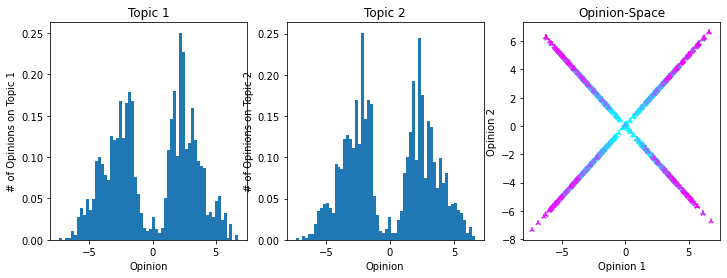

In [12]:
Plot_Opinion_Distribution_2d(data_1[len(data_1)-2], data_1[len(data_1)-1], data_1[0])